# Avaliador de Posições de Xadrez

O xadrez tem sido uma referência clássica para inteligência artificial, aprendizado de máquinas e mineração de dados desde sua criação. Devido às simples regras determinísticas do xadrez aliadas às possibilidades exponenciais e difíceis de avaliar posições, ganhou o foco de muitos pesquisadores em Ciência da Computação. Hoje em dia, existem vários IAs de xadrez sofisticados que competem em um nível acima até mesmo do mais forte Grande Mestre de xadrez do mundo. Enquanto as máquinas de xadrez como Stockfish (do qual este conjunto de dados é baseado) e AlphaGo são muito complexas para tentar competir aqui, vamos ver se podemos usar as avaliações de Stockfish para construir uma função de avaliação de posição comparável.

Para este projeto estarei usando a biblioteca de pytorch e construindo com ela uma Rede Neural.

from google.colab import drive
drive.mount('/content/drive')

In [1]:
# pytorch libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# for visualizing the results
import numpy as np
import matplotlib.pyplot as plt

# for reading input data
import pandas as pd

# for parsing the FEN of chess positions
import re

# Measuring time in seconds:

from timeit import default_timer as timer
from datetime import timedelta
import chess

Para representar uma posição de xadrez, é comum usar [Forsyth-Edwards Notation (FEN)](http://https://en.wikipedia.org/wiki/Forsyth%E2%80%93Edwards_Notation) que contém todas as informações necessárias para reconstruir um jogo de xadrez a partir da posição atual. Para tornar estas informações utilizáveis para uma rede neural, usaremos um byte para representar se uma peça específica (torre branca, cavaleiro branco, etc...) está em um quadrado específico no tabuleiro de xadrez 8x8. Como há 6 peças diferentes e dois jogadores diferentes, isso significa que há 12 peças específicas que poderiam estar potencialmente em cada quadrado. 

No entanto, ainda precisamos manter um registro de informações como de quem é a vez, quais opções de castling ainda são legais, se en passant é possível, quantas meias jogadas desde uma jogada de peão ou captura de peças, e quantas jogadas o jogo já teve. Para fazer isso, usamos um tabuleiro adicional 8x8 onde as posições das torres representam direitos de castling, a 3ª e 6ª posições (fileira) mantêm registro de possíveis jogadas en passant, os e1 e e8 representam quem está em movimento, e a 4ª e 5ª posições representam o número de meias jogadas e jogadas completas como números binários (máximo possível é 255), respectivamente.

Abaixo está uma função para fazer esta conversão.

In [2]:
def fen_to_bit_vector(fen):
    # piece placement - lowercase for black pieces, uppercase for white pieces. numbers represent consequtive spaces. / represents a new row 
    # active color - whose turn it is, either 'w' or 'b'
    # castling rights - which castling moves are still legal K or k for kingside and Q or q for queenside, '-' if no legal castling moves for either player
    # en passant - if the last move was a pawn moving up two squares, this is the space behind the square for the purposes of en passant
    # halfmove clock - number of moves without a pawn move or piece capture, after 50 of which the game is a draw
    # fullmove number - number of full turns starting at 1, increments after black's move

    # Example FEN of starting position
    # rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1
    
    parts = re.split(" ", fen)
    piece_placement = re.split("/", parts[0])
    active_color = parts[1]
    castling_rights = parts[2]
    en_passant = parts[3]
    halfmove_clock = int(parts[4])
    fullmove_clock = int(parts[5])

    bit_vector = np.zeros((13, 8, 8), dtype=np.uint8)
    
    # piece to layer structure taken from reference [1]
    piece_to_layer = {
        'R': 1,
        'N': 2,
        'B': 3,
        'Q': 4,
        'K': 5,
        'P': 6,
        'p': 7,
        'k': 8,
        'q': 9,
        'b': 10,
        'n': 11,
        'r': 12
    }
    
    castling = {
        'K': (7,7),
        'Q': (7,0),
        'k': (0,7),
        'q': (0,0),
    }

    for r, row in enumerate(piece_placement):
        c = 0
        for piece in row:
            if piece in piece_to_layer:
                bit_vector[piece_to_layer[piece], r, c] = 1
                c += 1
            else:
                c += int(piece)
    
    if en_passant != '-':
        bit_vector[0, ord(en_passant[0]) - ord('a'), int(en_passant[1]) - 1] = 1
    
    if castling_rights != '-':
        for char in castling_rights:
            bit_vector[0, castling[char][0], castling[char][1]] = 1
    
    if active_color == 'w':
        bit_vector[0, 7, 4] = 1
    else:
        bit_vector[0, 0, 4] = 1

    if halfmove_clock > 0:
        c = 7
        while halfmove_clock > 0:
            bit_vector[0, 3, c] = halfmove_clock%2
            halfmove_clock = halfmove_clock // 2
            c -= 1
            if c < 0:
                break

    if fullmove_clock > 0:
        c = 7
        while fullmove_clock > 0:
            bit_vector[0, 4, c] = fullmove_clock%2
            fullmove_clock = fullmove_clock // 2
            c -= 1
            if c < 0:
                break

    return bit_vector



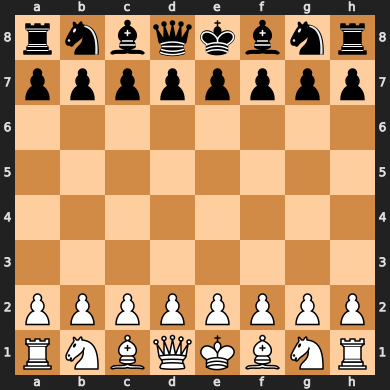

In [3]:
fen = "rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1"

chess.Board(fen)


O primeiro tabuleiro 8x8 (0º índice) contém todas as informações extras e os 12 tabuleiros seguintes (1 a 12) representam a localização das peças na ordem 

1. Torre branca
2. Cavaleiro Branco
3. Bispo Branco
4. Rainha Branca
5. Rei Branco
6. Peão Branco
7. Peão Preto
8. Rei Negro
9. Rainha Negra
10. Bispo negro
11. Cavaleiro Negro
12. Torre Negra

Observe como as peças se alinham corretamente com a posição inicial com o primeiro tabuleiro indicando corretamente que está na vez da branca se mover.

# Rede Neural

Começaremos com uma simples Rede Neural Feed-Forward que está totalmente conectada. As Redes Neurais são nomeadas por sua estrutura ser análoga à dos neurônios no cérebro humano. A idéia é que, no cérebro humano, quando um neurônio recebe um impulso elétrico através de suas sinapses, ele às vezes dispara um impulso elétrico para outros neurônios, criando uma reação em cadeia. Para as redes neurais, nossos neurônios são nós, nossas sinapses são bordas (com pesos correspondentes) e a queima do neurônio é a função de ativação e saída do nó. 

![Perceptron](http://starship-knowledge.com/wp-content/uploads/2020/10/Perceptrons-1024x724.jpeg)

O objetivo da Rede Neural é ter pesos tais que, após todas as reações em cadeia dos nós que recebem entradas e produzem saídas, a saída de informações do nó final represente a avaliação da posição do xadrez que iniciou o processo. Para encontrar realmente tais pesos, usaremos um método conhecido como retropropagação, que ajusta iterativamente os pesos na rede para aproximar a saída da resposta que desejamos.

Tecnicamente falando, para cada registro de treinamento (um FEN e uma avaliação) inserimos a posição na Rede Neural, e após obter um resultado, calculamos o erro entre o resultado e a avaliação correta que pode ser representada como uma função de erro. Para alterar os pesos de forma a minimizar esta função de erro, calculamos o gradiente da função de erro e ajustamos os pesos na direção oposta. Isto significa que, se excedermos, queremos diminuir nossa avaliação e, se não conseguirmos, queremos aumentar nossa avaliação.

![Gradiente de descida](https://sebastianraschka.com/images/blog/2015/singlelayer_neural_networks_files/perceptron_gradient_descent_1.png)


In [4]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(832, 832)
        self.fc2 = nn.Linear(832, 416)
        self.fc3 = nn.Linear(416, 208)
        self.fc4 = nn.Linear(208, 104)
        self.fc5 = nn.Linear(104, 1)


    def forward(self, x):
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x



In [5]:
# ChessDataset code and eval_to_int code taken from reference [1]
class ChessDataset(Dataset):
    def __init__(self, data_frame):
        self.fens = torch.from_numpy(np.array([*map(fen_to_bit_vector, data_frame["FEN"])], dtype=np.float32))
        self.evals = torch.Tensor([[x] for x in data_frame["Evaluation"]])
        self._len = len(self.evals)
        
    def __len__(self):
        return self._len
    
    def __getitem__(self, index):
        return self.fens[index], self.evals[index]


def eval_to_int(evaluation):
    try:
        res = int(evaluation)
    except ValueError:
        res = 10000 if evaluation[1] == '+' else -10000
    return res / 100



In [6]:
def AdamW_main(trainloader, testloader, batch_size, epochs, device):
    
    net = Net().to(device)
    criterion = nn.MSELoss()
    optimizer = optim.AdamW(net.parameters())

    for epoch in range(epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            # if i == len(trainloader):    # print every 2000 mini-batches
            #     # denominator for loss should represent the number of positions evaluated 
            #     # independent of the batch size
            #     print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / (1000*len(labels))))
            #     running_loss = 0.0

            # print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / (1000*len(labels))))
        # print('epoch: %d - running loss: %.5f'% (epoch, running_loss/len(trainset)))
        running_loss = 0.0
            
    # print('Finished Training')

    # PATH = './chess.pth'
    # torch.save(net.state_dict(), PATH)

    # print('Evaluating model')

    count = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in testloader:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            #print("Correct eval: {}, Predicted eval: {}, loss: {}".format(labels, outputs, loss))
            
            # count should represent the number of positions evaluated 
            # independent of the batch size
            count += len(labels)
         
            # if count % 10000 == 0:
            #     print('model on the {} tactics positions is {}'.format(count, loss/count))
    print('AdamW MSE: %.5f'%(loss/count))
    return 'AdamW MSE: %.5f'%(loss/count)

In [7]:
def SGD_main(trainloader, testloader, batch_size, epochs, device, learning_rate):

    net = Net().to(device)
    criterion = nn.MSELoss()
    optimizer = optim.SGD(net.parameters(), lr = learning_rate)
    
    for epoch in range(epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            # if i % 2000 == 0:    # print every 1000 mini-batches
            #     # denominator for loss should represent the number of positions evaluated 
            #     # independent of the batch size
            #     print('[%d, %d] loss: %.3f' % (epoch + 1, i + 1, running_loss / (1000*len(labels))))
            #     running_loss = 0.0
#         print('epoch {} - running_loss {} - len(trainset) {}'.format(epoch, running_loss, len(trainset)))
        # print('epoch: %d - running loss: %.5f' % (epoch, float(running_loss/len(trainset))))
#         print('epoch: {} - running loss: {}'.format(epoch, running_loss/dataSize))
        running_loss = 0.0

    # print('Finished Training')

    # PATH = './chess.pth'
    # torch.save(net.state_dict(), PATH)

    # print('Evaluating model')

    count = 0
    total_loss = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in testloader:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            #print("Correct eval: {}, Predicted eval: {}, loss: {}".format(labels, outputs, loss))
            
            # count should represent the number of positions evaluated 
            # independent of the batch size
            count += len(labels)
            total_loss += loss
            # if count % 10000 == 0:
            #     print('model on the {} tactics positions is {}'.format(count, loss/count))
    print('SGD %.3f MSE: %.5f'%(learning_rate, loss/count))
    return 'SGD %.3f MSE: %.5f'%(learning_rate, loss/count)


In [8]:
FILE_PATH = './'
print("Preparing Training Data...")
train_data = pd.read_csv(FILE_PATH + "chessData.csv")
# print("total chessData size:",train_data.shape[0]/10**6,"m (", train_data.shape[0],")")

print("Preparing Test Data...")
test_data = pd.read_csv(FILE_PATH + "tactic_evals.csv")
# print("total: tactic_evals size:",test_data.shape[0]//10**6,"m(", test_data.shape[0],")")

def run_models(MAX_DATA, BATCH_SIZE = 10, EPOCHS = 10, DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu"), train_data=train_data, test_data=test_data):
    
    # print("Using device {}".format(DEVICE))

    print("Preparing Training Data...")
    train_data = train_data[:MAX_DATA]
    train_data["Evaluation"] = train_data["Evaluation"].map(eval_to_int)
    trainset = ChessDataset(train_data)

    print("Preparing Test Data...")
    test_data = test_data[:MAX_DATA]
    test_data["Evaluation"] = test_data["Evaluation"].map(eval_to_int)
    testset = ChessDataset(test_data)

    # print("Converting to pytorch Dataset...")

    trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
    testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)    
    
    print("total data: {}".format(len(trainset)))
    print("-"*50)
    
    print("AdamW")
    start = timer()
    AdamW = AdamW_main(trainloader, testloader, BATCH_SIZE, EPOCHS, DEVICE)
    end = timer()
    print('time elapsed on AdamW:', timedelta(seconds=end-start))
    print("-"*50)

    print("SGD 0.01")
    start = timer()
    SGD_01 = SGD_main(trainloader, testloader, BATCH_SIZE, EPOCHS, DEVICE, 0.01)
    end = timer()
    print('time elapsed on SGD 0.01:', timedelta(seconds=end-start))

    print("-"*50)

    print("SGD 0.001")
    start = timer()
    SGD_001 = SGD_main(trainloader, testloader, BATCH_SIZE, EPOCHS, DEVICE, 0.001)
    end = timer()
    print('time elapsed on SGD - 0.001:', timedelta(seconds=end-start))

    print("-"*50)
    params = f"MAX DATA: {MAX_DATA} - BATCH_SIZE: {BATCH_SIZE} EPOCHS: {EPOCHS}"
    print(params)
    print(AdamW) 
    print(SGD_01) 
    print(SGD_001)
    return (params, AdamW, SGD_01, SGD_001)

Preparing Training Data...
Preparing Test Data...


In [9]:
_MAX_DATA = [10, 20, 30]
_BATCH_SIZE = [10, 20, 30]
_EPOCHS = [10, 20, 30]
results = []
for m in range(0,3):
    # Permutatig MAX DATA
    for b in range(0,3):
        # Permutating BATCH_SIZE
        for e in range(0,3):
            # Permutating EPOCHS
            # print("MAX_DATA:",_MAX_DATA[m],"BATCH_SIZE:",_BATCH_SIZE[b],"EPOCHS:",_EPOCHS[e])
            result = run_models(_MAX_DATA[m], BATCH_SIZE=_BATCH_SIZE[b], EPOCHS=_EPOCHS[e])
            results.append(result)
            print('-'*50)

Preparing Training Data...


C:\Users\Rubens\AppData\Local\Temp\ipykernel_16724\2460897923.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data["Evaluation"] = train_data["Evaluation"].map(eval_to_int)
C:\Users\Rubens\AppData\Local\Temp\ipykernel_16724\2460897923.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data["Evaluation"] = test_data["Evaluation"].map(eval_to_int)


Preparing Test Data...
total data: 10
--------------------------------------------------
AdamW
AdamW MSE: 698.16925
time elapsed on AdamW: 0:00:01.630504
--------------------------------------------------
SGD 0.01
SGD 0.010 MSE: 700.33087
time elapsed on SGD 0.01: 0:00:00.023235
--------------------------------------------------
SGD 0.001
SGD 0.001 MSE: 701.72784
time elapsed on SGD - 0.001: 0:00:00.022358
--------------------------------------------------
MAX DATA: 10 - BATCH_SIZE: 10 EPOCHS: 10
AdamW MSE: 698.16925
SGD 0.010 MSE: 700.33087
SGD 0.001 MSE: 701.72784
--------------------------------------------------
Preparing Training Data...
Preparing Test Data...
total data: 10
--------------------------------------------------
AdamW
AdamW MSE: 695.39447
time elapsed on AdamW: 0:00:00.057780
--------------------------------------------------
SGD 0.01
SGD 0.010 MSE: 698.33923
time elapsed on SGD 0.01: 0:00:00.040599
--------------------------------------------------
SGD 0.001
SGD 0.00

In [10]:
for i in results:
    print(i)

('MAX DATA: 10 - BATCH_SIZE: 10 EPOCHS: 10', 'AdamW MSE: 698.16925', 'SGD 0.010 MSE: 700.33087', 'SGD 0.001 MSE: 701.72784')
('MAX DATA: 10 - BATCH_SIZE: 10 EPOCHS: 20', 'AdamW MSE: 695.39447', 'SGD 0.010 MSE: 698.33923', 'SGD 0.001 MSE: 700.76721')
('MAX DATA: 10 - BATCH_SIZE: 10 EPOCHS: 30', 'AdamW MSE: 695.25702', 'SGD 0.010 MSE: 698.44141', 'SGD 0.001 MSE: 701.47235')
('MAX DATA: 10 - BATCH_SIZE: 20 EPOCHS: 10', 'AdamW MSE: 698.07172', 'SGD 0.010 MSE: 699.46838', 'SGD 0.001 MSE: 701.11859')
('MAX DATA: 10 - BATCH_SIZE: 20 EPOCHS: 20', 'AdamW MSE: 697.20831', 'SGD 0.010 MSE: 698.54059', 'SGD 0.001 MSE: 700.93719')
('MAX DATA: 10 - BATCH_SIZE: 20 EPOCHS: 30', 'AdamW MSE: 695.44049', 'SGD 0.010 MSE: 698.23962', 'SGD 0.001 MSE: 699.45856')
('MAX DATA: 10 - BATCH_SIZE: 30 EPOCHS: 10', 'AdamW MSE: 698.05487', 'SGD 0.010 MSE: 700.14417', 'SGD 0.001 MSE: 701.54150')
('MAX DATA: 10 - BATCH_SIZE: 30 EPOCHS: 20', 'AdamW MSE: 697.68970', 'SGD 0.010 MSE: 698.79584', 'SGD 0.001 MSE: 699.41534')


# Resultados de AdamW

Um erro médio de 0,0225 parece muito razoável, porém isto não é tão surpreendente quanto poderia parecer a princípio, já que as posições onde a avaliação do stockfish não são um par forçado, foram normalizadas para uma faixa de aproximadamente -1,5 a 1,5 e as posições onde a avaliação do stockfish é um par forçado foram definidas para -100 ou 100. Por convenção, uma pontuação positiva indica uma vantagem para o branco e uma pontuação negativa indica uma vantagem para o preto.

# Testando com SGD

Originalmente usamos o algoritmo AdamW para a etapa de otimização, mas e se tentarmos a Descendência Estocástica Gradiente (SGD)?

Um erro médio de 0,0207 é uma ligeira melhoria, mas não tanto que possamos dizer definitivamente que o SGD fez melhor do que AdamW. Como a perda de treinamento não diminuiu muito ao longo das 10 épocas, é muito mais provável que o SGD seja um otimizador pior para este problema de classificação ou que a taxa de aprendizado seja muito grande, o que está impedindo o modelo de convergir para o ótimo local. Vamos tentar novamente, mas com uma taxa de aprendizado de 0,001

O erro de treinamento parece estar diminuindo mesmo que esporádico, mas o erro de classificação ficou um pouco pior. Parece que o AdamW é simplesmente mais consistente e converge mais rapidamente para um ótimo local.

# Conclusão

AdamW parece ser um algoritmo mais consistente e que converge mais rapidamente para um ótimo local baseado na comparação de AdamW, SGD(lr=0,01), e SGD(lr=0,001)

Isto significa que o melhor modelo teve um erro médio de 0,0225, em oposição ao erro médio mais baixo de 0,0207, que não é suficientemente significativo para justificar a inconsistência do otimizador SGD.

# Desafios

Este conjunto de dados (ou pelo menos o conjunto de dados chessData.csv) tem mais de 16 milhões de posições e avaliações, o que torna bastante difícil trabalhar com ele. Por causa disso, tive que limitar a quantidade de dados realmente utilizada a 200.000 posições, 100.000 no conjunto de dados de treinamento e 100.000 no conjunto de dados de teste. 

# Referências

1. https://www.kaggle.com/ronakbadhe/chess-evaluation-prediction
2. https://en.wikipedia.org/wiki/Forsyth%E2%80%93Edwards_Notation
3. http://starship-knowledge.com/wp-content/uploads/2020/10/Perceptrons-1024x724.jpeg
4. https://starship-knowledge.com/wp-content/uploads/2020/10/Perceptrons-1024x724.jpeg

# Contribution

* Representation of castling rights, en passant, active color, halfmoves and fullmoves in an 8x8 grid
* Neural Network Architecture
* Testing AdamW vs SVG